# Data Downloading 
### Kaggle and Kagglehub packages are installed to get the data 


In [5]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 3.0 MB/s eta 0:00:0031m2.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification 


Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors


In [1]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", "/home/rjaswal1634/Project_520/")

Path to dataset files: /home/rjaswal1634/Project_520/unprepared_data


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Visualization of the data Distribution

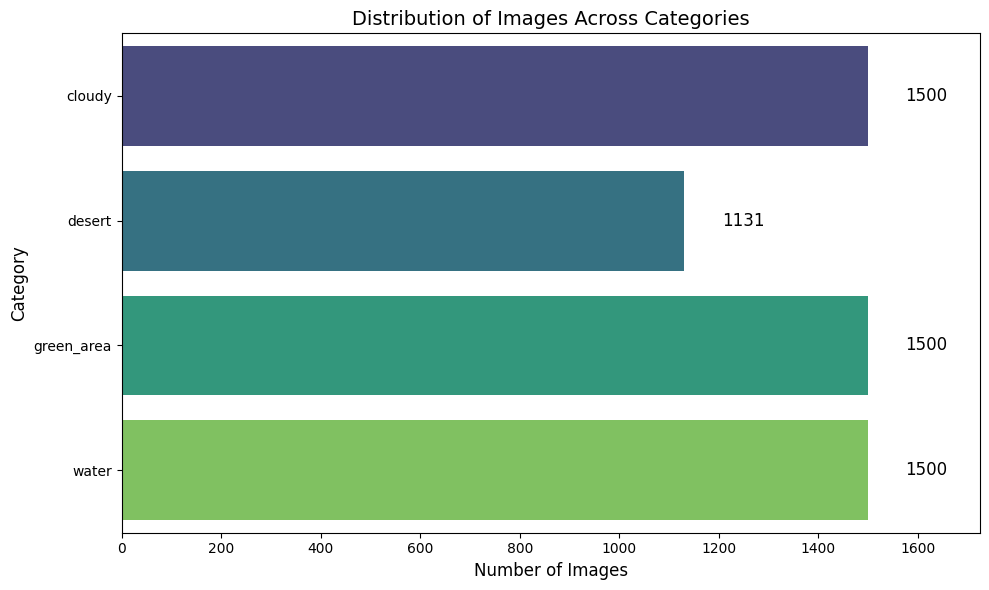

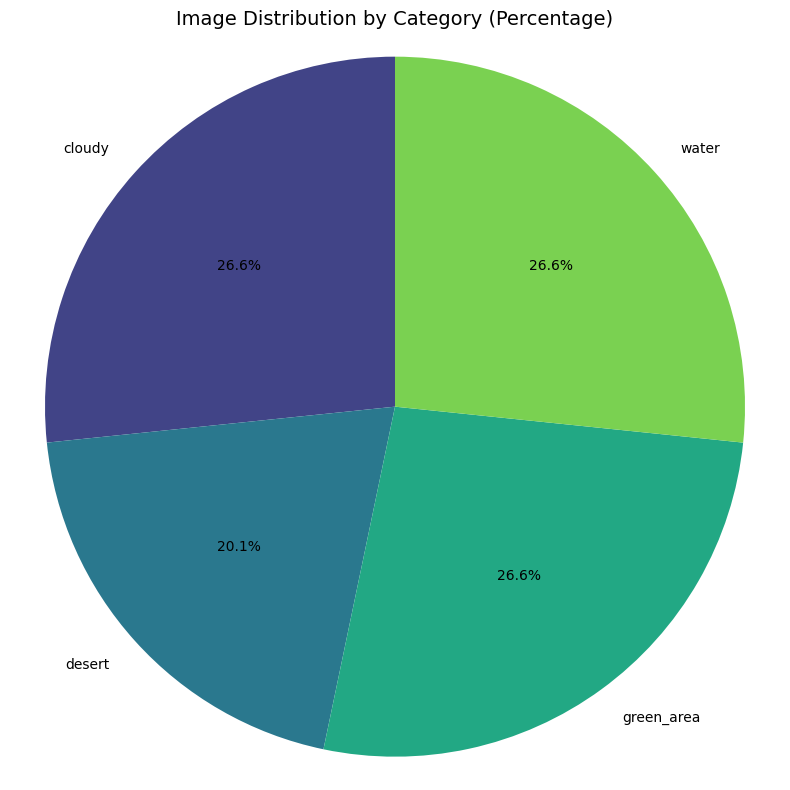

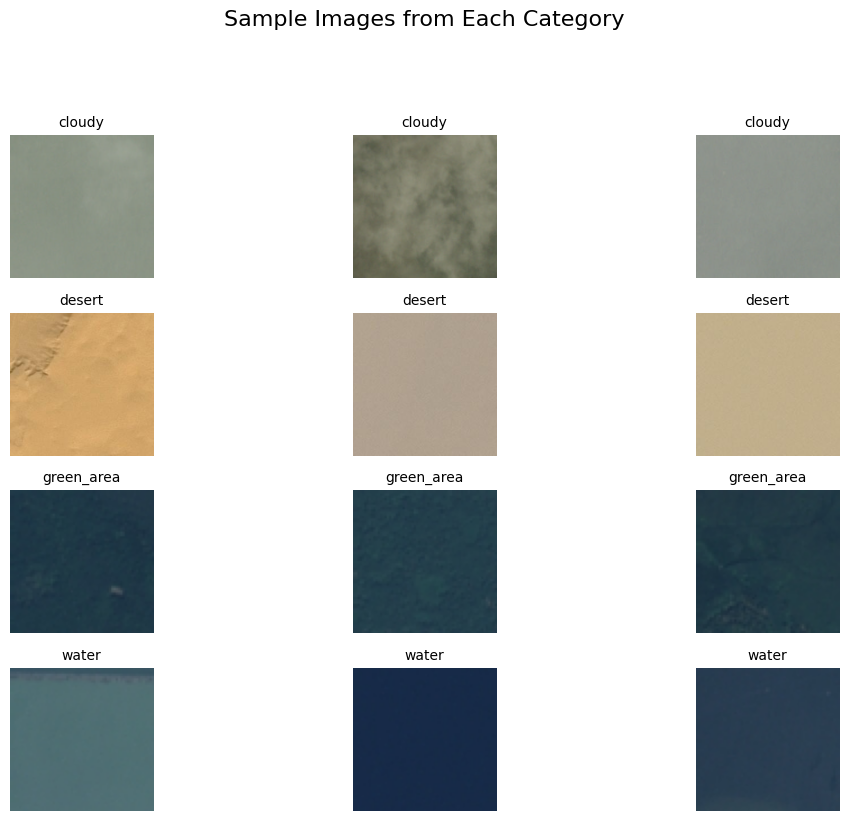

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Set up paths and categories
data_dir = "unprocessed_data"
classes = ["cloudy", "desert", "green_area", "water"]
output_dir = "visuals"
os.makedirs(output_dir, exist_ok=True)

# 1. Count images in each category
image_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    image_counts[cls] = len(images)

# 2. Bar plot: Distribution of Images
plt.figure(figsize=(10, 6))  # Slightly wider figure

# Updated barplot call using hue parameter and legend=False
sns.barplot(
    x=list(image_counts.values()), 
    y=list(image_counts.keys()), 
    hue=list(image_counts.keys()), 
    palette="viridis",
    legend=False
)

plt.title("Distribution of Images Across Categories", fontsize=14)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Category", fontsize=12)

# Calculate the maximum bar length to better position text
max_count = max(image_counts.values())
padding = max_count * 0.05  # 5% padding

# Position text with better spacing
for i, count in enumerate(image_counts.values()):
    plt.text(count + padding, i, str(count), va="center", fontsize=12)

# Make sure the x-axis extends beyond the longest bar to accommodate text
plt.xlim(0, max_count * 1.15)  # Add 15% extra space for labels

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distribution_barplot.jpg"), format="jpg", dpi=300)
plt.show()


## 3. Pie chart: Image Distribution
plt.figure(figsize=(8, 8))  # Square figure for better pie chart proportions
plt.pie(
    image_counts.values(),
    labels=image_counts.keys(),
    autopct="%1.1f%%",
    colors=sns.color_palette("viridis", len(classes)),
    startangle=90  # Start at top
)
plt.title("Image Distribution by Category (Percentage)", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distribution_piechart.jpg"), format="jpg", dpi=300)
plt.show()

# 4. Sample Images from Each Category
num_samples = 3
fig = plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    for j in range(min(num_samples, len(images))):
        img_path = os.path.join(class_path, images[j])
        img = Image.open(img_path)
        plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        plt.title(cls, fontsize=10)
        plt.axis("off")

plt.suptitle("Sample Images from Each Category", fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout while preserving space for suptitle
plt.savefig(os.path.join(output_dir, "sample_images.jpg"), format="jpg", dpi=300)
plt.show()

# Using Data Augmentation Techniques to Make the data distrubution Equal

In [5]:
pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
from PIL import Image
import albumentations as A
import random

# Path to the dataset
data_dir = os.path.join("unprocessed_data")
classes = ["cloudy", "desert", "green_area", "water"]

# Count images in each category
image_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    image_counts[cls] = len(images)

print("Original counts:", image_counts)

# Target count (match other classes)
target_count = 1500
desert_images = [f for f in os.listdir(os.path.join(data_dir, "desert")) if f.endswith(".jpg")]
num_to_generate = target_count - len(desert_images)  # 369 images needed

# Define augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=90, p=0.5),  # Rotate up to 90 degrees
    A.HorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    A.VerticalFlip(p=0.5),  # 50% chance of vertical flip
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness/contrast
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Color jitter
    A.RandomCrop(height=200, width=200, p=0.3),  # Random crop (then resize back)
    A.Resize(height=224, width=224),  # Resize to match EfficientNet input
])

# Generate new desert images
generated_count = 0
desert_path = os.path.join(data_dir, "desert")
while generated_count < num_to_generate:
    # Randomly select an image to augment
    img_name = random.choice(desert_images)
    img_path = os.path.join(desert_path, img_name)
    
    # Load image
    img = np.array(Image.open(img_path))
    
    # Apply augmentations
    augmented = augmentations(image=img)
    aug_img = augmented["image"]
    
    # Save the augmented image with a new name
    base_name, ext = os.path.splitext(img_name)
    new_img_name = f"{base_name}_aug_{generated_count}{ext}"
    new_img_path = os.path.join(desert_path, new_img_name)
    Image.fromarray(aug_img).save(new_img_path)
    
    generated_count += 1

# Verify new counts
new_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    new_counts[cls] = len(images)

print("New counts after augmentation:", new_counts)

Original counts: {'cloudy': 1500, 'desert': 1131, 'green_area': 1500, 'water': 1500}
New counts after augmentation: {'cloudy': 1500, 'desert': 1500, 'green_area': 1500, 'water': 1500}


# Visualization After the Distrubition

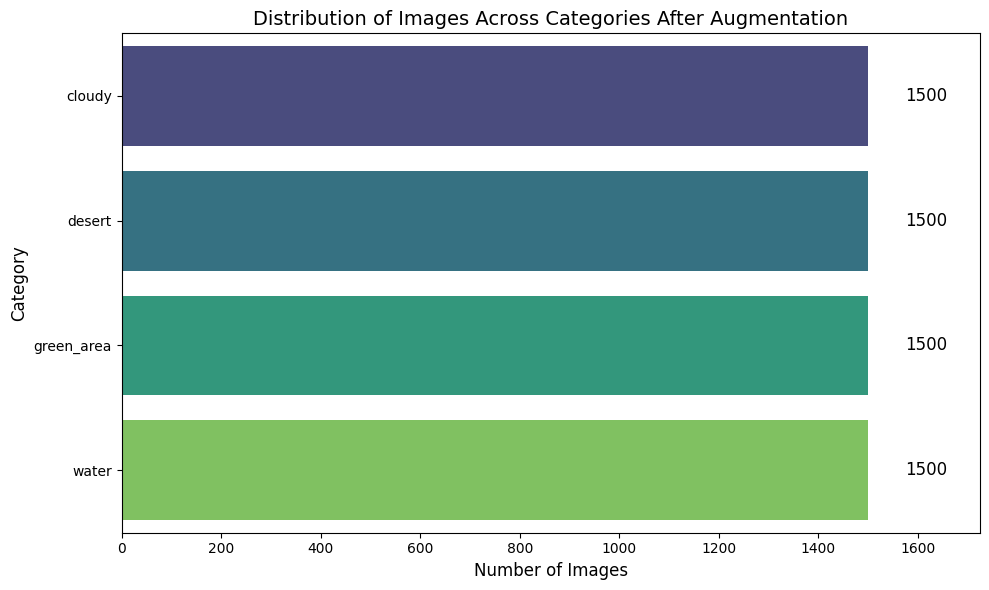

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recount images
image_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    image_counts[cls] = len(images)


plt.figure(figsize=(10, 6))  # Slightly wider figure

sns.barplot(
    x=list(image_counts.values()), 
    y=list(image_counts.keys()), 
    hue=list(image_counts.keys()), 
    palette="viridis",
    legend=False
)

plt.title("Distribution of Images Across Categories After Augmentation", fontsize=14)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Category", fontsize=12)

# Calculate the maximum bar length to better position text
max_count = max(image_counts.values())
padding = max_count * 0.05  # 5% padding

# Position text with better spacing
for i, count in enumerate(image_counts.values()):
    plt.text(count + padding, i, str(count), va="center", fontsize=12)

# Make sure the x-axis extends beyond the longest bar to accommodate text
plt.xlim(0, max_count * 1.15)  # Add 15% extra space for labels

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distribution_barplot_aug.jpg"), format="jpg", dpi=300)
plt.show()

# Colour Channel Analysis Across different Categories

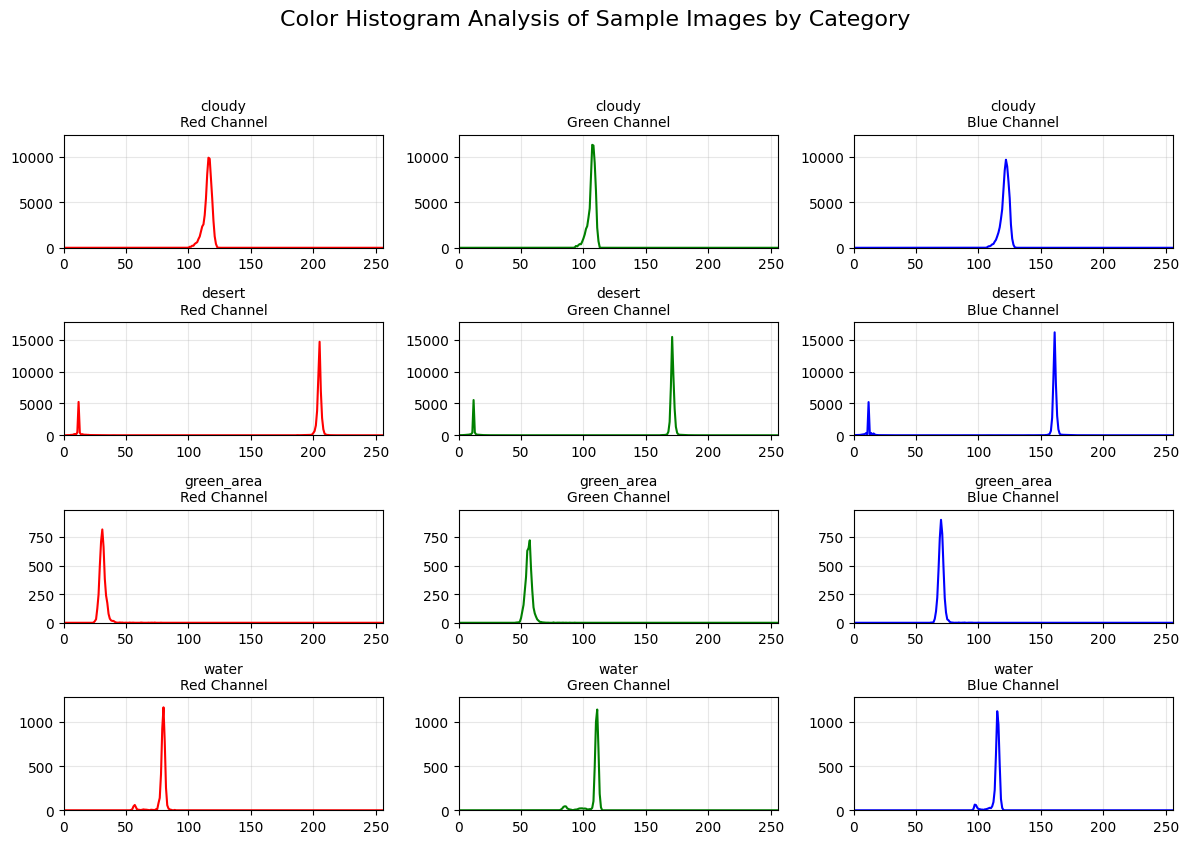

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the dataset
data_dir = os.path.join("unprocessed_data")
classes = ["cloudy", "desert", "green_area", "water"]
output_dir = "visuals"
# Set up the plot
fig, axes = plt.subplots(len(classes), 3, figsize=(12, 8))  # 3 columns: R, G, B histograms
plt.suptitle("Color Histogram Analysis of Sample Images by Category", fontsize=16, y=1.05)

for i, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    
    # Take the first image
    img_path = os.path.join(class_path, images[0])
    img = np.array(Image.open(img_path))
    
    # Compute histograms for each channel
    r_hist = np.histogram(img[:, :, 0], bins=256, range=(0, 256))[0]  # Red channel
    g_hist = np.histogram(img[:, :, 1], bins=256, range=(0, 256))[0]  # Green channel
    b_hist = np.histogram(img[:, :, 2], bins=256, range=(0, 256))[0]  # Blue channel
    
    # Plot histograms
    axes[i, 0].plot(r_hist, color="red", label="Red")
    axes[i, 0].set_title(f"{cls}\nRed Channel", fontsize=10)
    axes[i, 0].set_xlim(0, 256)
    axes[i, 0].set_ylim(0, np.max([r_hist, g_hist, b_hist]) * 1.1)  # Adjust y-axis for visibility
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].plot(g_hist, color="green", label="Green")
    axes[i, 1].set_title(f"{cls}\nGreen Channel", fontsize=10)
    axes[i, 1].set_xlim(0, 256)
    axes[i, 1].set_ylim(0, np.max([r_hist, g_hist, b_hist]) * 1.1)
    axes[i, 1].grid(True, alpha=0.3)
    
    axes[i, 2].plot(b_hist, color="blue", label="Blue")
    axes[i, 2].set_title(f"{cls}\nBlue Channel", fontsize=10)
    axes[i, 2].set_xlim(0, 256)
    axes[i, 2].set_ylim(0, np.max([r_hist, g_hist, b_hist]) * 1.1)
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "colour_analysis.jpg"), format="jpg", dpi=300, bbox_inches="tight")
plt.show()


# Spliting the Data in Training, Validation and Testing (80/10/10)

In [13]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1):
    """
    Split dataset into train, val, and test sets.
    Args:
        source_dir: Path to dataset (e.g., 'satellite_images/')
        dest_dir: Path to output (e.g., 'processed_data/')
        train_ratio: Fraction for training (default: 0.8)
        val_ratio: Fraction for validation (default: 0.1)
    """
    # Create destination directories
    os.makedirs(dest_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for cls in ['cloudy', 'desert', 'green_area', 'water']:
            os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)
    
    # Get class folders
    classes = ['cloudy', 'desert', 'green_area', 'water']
    
    for cls in classes:
        # Get all images in the class folder
        class_dir = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)  # Shuffle images
        
        # Calculate split indices
        total_images = len(images)
        train_end = int(train_ratio * total_images)
        val_end = train_end + int(val_ratio * total_images)
        
        # Split images
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]
        
        # Copy images to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(dest_dir, 'train', cls, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(dest_dir, 'val', cls, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(dest_dir, 'test', cls, img))
        
        print(f"Class {cls}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

# Run the split
source_dir = 'unprocessed_data'
dest_dir = 'processed_data'
split_dataset(source_dir, dest_dir)
print("Dataset split into 'processed_data/train/', 'processed_data/val/', and 'processed_data/test/'")

Class cloudy: 1200 train, 150 val, 150 test
Class desert: 1200 train, 150 val, 150 test
Class green_area: 1200 train, 150 val, 150 test
Class water: 1200 train, 150 val, 150 test
Dataset split into 'processed_data/train/', 'processed_data/val/', and 'processed_data/test/'


# Visualization of the Split

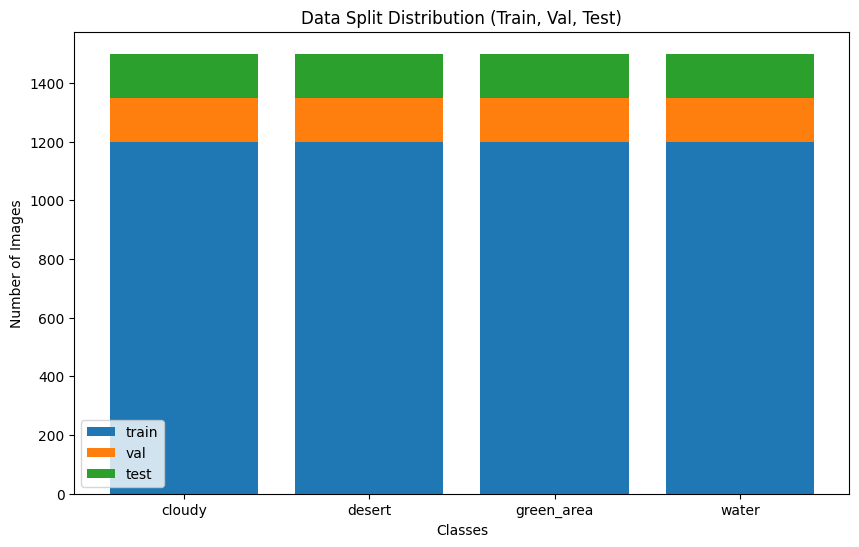

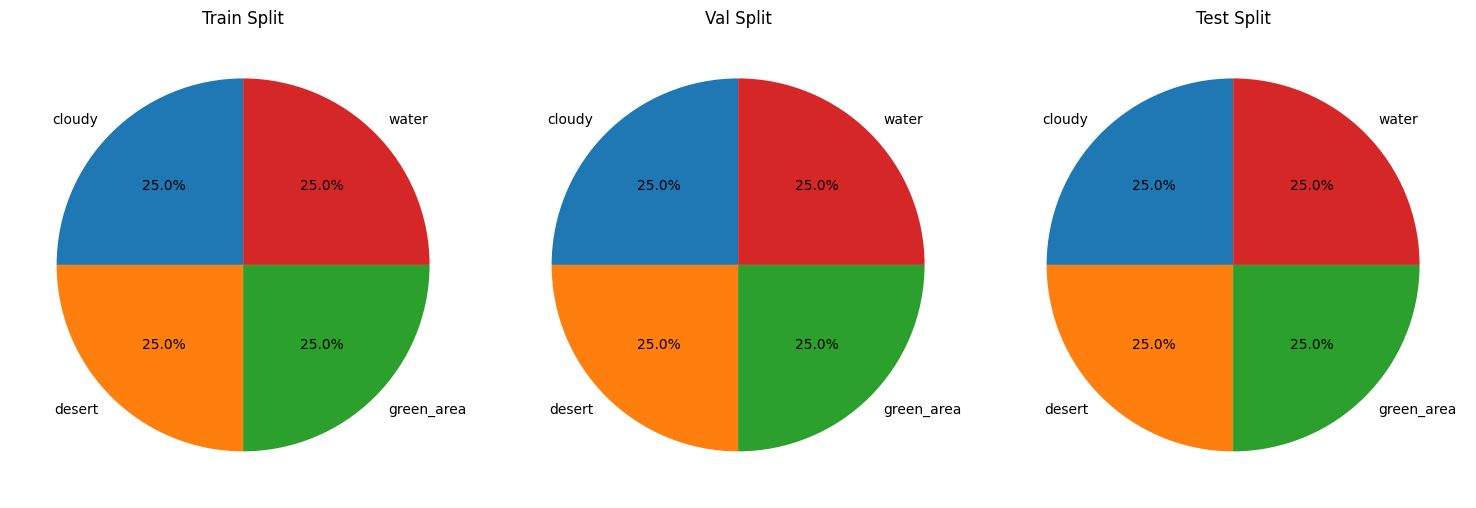

Visualizations saved as 'data_split_bar.png' and 'data_split_pie.png'


In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_split(data_dir):
    """
    Visualize the data split with a stacked bar chart and pie charts.
    Args:
        data_dir: Path to processed dataset (e.g., 'processed_data/')
    """
    classes = ['cloudy', 'desert', 'green_area', 'water']
    splits = ['train', 'val', 'test']
    counts = {split: [] for split in splits}
    
    # Count images per class for each split
    for split in splits:
        for cls in classes:
            class_dir = os.path.join(data_dir, split, cls)
            num_images = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            counts[split].append(num_images)
    
    # Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(len(classes))
    for split in splits:
        ax.bar(classes, counts[split], label=split, bottom=bottom)
        bottom += np.array(counts[split])
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Data Split Distribution (Train, Val, Test)')
    ax.legend()
    
    plt.savefig('data_split_bar.png')
    plt.show()
    
    # Pie Charts for Each Split
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, split in enumerate(splits):
        axes[i].pie(counts[split], labels=classes, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'{split.capitalize()} Split')
    
    plt.tight_layout()
    plt.savefig('data_split_pie.png')
    plt.show()

# Run visualization
data_dir = 'processed_data'
visualize_data_split(data_dir)
print("Visualizations saved as 'data_split_bar.png' and 'data_split_pie.png'")

# The visualiztion shows equal distrubution of data across all the categories and the folders. 